# Benchmark #1:

Implement the SP algorithm [June 9 - June 26]

Benchmark the SP algorithm [June 26 - July 3]

* **Demonstrate**: 
    1. Distributed run with multiple workers
    2. Scaling of `@elapesed` time with `# workers`
    3. Scaling of `@CPUelapsed` time with `# workers`
    4. Consistency of AHMI integral
    5. KS test


* **Approach**: 

    1. Define a target density function
    2. Generate a fixed number of samples [$1.5*10^7$] for different settings (`# workers`, `# subspaces`)
        - `# workers` = [1, 2, 5, 15, 25]
        - `# CPU/worker` = `# threads` = `# chains` = 10
        - `# subspaces` = 1 - 150
   

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using HDF5
using CSV

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using PyPlot

In [4]:
# using Revise
using BAT

## Functions: 

In [5]:
function convert_to_typed_table(table)
    density_integral = [Measurements.measurement(parse.(Float64, split(v_run, " ± "))...) for v_run in table.density_integral]
    integration_cpu_time = collect(table.integration_cpu_time)
    sampling_cpu_time = collect(table.sampling_cpu_time)
    n_threads = collect(table.n_threads)
    worker_id = collect(table.worker_id)
    sum_weights = collect(table.sum_weights)
    samples_ind = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.samples_ind ]
    sampling_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.sampling_wc ]
    integration_wc = [UnitRange(parse.(Int64, split(v_run, ":"))...) for v_run in table.integration_wc ]
    
    TypedTables.Table(
        density_integral=density_integral,
        integration_cpu_time=integration_cpu_time,
        sampling_cpu_time=sampling_cpu_time,
        n_threads=n_threads,
        worker_id=worker_id,
        sum_weights=sum_weights,
        samples_ind=samples_ind,
        sampling_wc=sampling_wc,
        integration_wc=integration_wc
    )
end

convert_to_typed_table (generic function with 1 method)

In [6]:
function plot_separated_timeline(data::T;figsize=(8,8)) where {T<:Table}
    
    minimum_timestamp = minimum([ts[1] for ts in data.sampling_wc])
    
    timestamps_shifted = [([
                data.sampling_wc[ts][1], data.sampling_wc[ts][end], 
                data.integration_wc[ts][1], data.integration_wc[ts][end]
                ] .- minimum_timestamp) .* 10^-9 for ts in 1:length(data.sampling_wc)]
    
    maximum_timestamp  = maximum(maximum.(timestamps_shifted))
    maximum_cpu_time = maximum([data.sampling_cpu_time..., data.integration_cpu_time...])
    
    proc_ids = collect(minimum(data.worker_id):maximum(data.worker_id))
    n_workers = length(proc_ids)
    
    x_min = 0
    x_max = maximum_timestamp
    y_min = 0
    y_max_tmp = Float64[]
    
    label_1 = "Sampling"
    label_2 = "Integration"
    
    @show n_workers, maximum(proc_ids)
    fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=figsize)
    fig.subplots_adjust(hspace=0.0, wspace=0.00)
  
    for (i,j) in enumerate(timestamps_shifted)

        r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], data.sampling_cpu_time[i]/(j[2]-j[1]), fill=true, 
            linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
        ax[data.worker_id[i] - 1].add_patch(r1)
        r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], data.integration_cpu_time[i]/(j[4]-j[3]), 
            fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
        ax[data.worker_id[i] - 1].add_patch(r2)

        push!(y_max_tmp, data.sampling_cpu_time[i]/(j[2]-j[1]))
        push!(y_max_tmp, data.integration_cpu_time[i]/(j[4]-j[3]))

        label_1 = "_nolegend_"
        label_2 = "_nolegend_"

    end

     ax[1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),)

    for i in 1:n_workers
        ax[i].set_xlim(x_min, x_max);
        ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
        ax[i].set_ylabel("w$i", labelpad=10,  size=10)

    #     ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=false)
        ax[i].grid(axis="y", which="both", alpha=0.2, )

        if i<n_workers
            ax[i].get_xaxis().set_visible(false) 
        end
    end

    fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
    ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")
    
end

plot_separated_timeline (generic function with 1 method)

In [7]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:9]);

function get_cpu_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    sum(table.integration_cpu_time)+sum(table.sampling_cpu_time)
end

function get_wc_time(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return (maximum([t[end] for t in table.integration_wc]) - minimum([t[1] for t in table.sampling_wc]))* 10^-9
end

function get_integrals(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return exp(log(sum(table.density_integral)) + 47.684856298932324)
end

function get_nsamples(name)
    csvfile = CSV.File(name)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    return table.samples_ind[end][end]
end

get_nsamples (generic function with 1 method)

In [8]:
function ksstats(
        x::AbstractVector{T},
        y::AbstractVector{S},
        w_x::AbstractVector{D},
        w_y::AbstractVector{M},
    ) where {T<:Real, S<:Real, D<:Real, M<:Real, R1<:Real, R2<:Real}
    
    sort_idx = sortperm([x; y])
    pdf_diffs = [w_x/sum(w_x); -w_y/sum(w_y)][sort_idx]
    cdf_diffs = cumsum(pdf_diffs)
    δp = maximum(cdf_diffs)
    δn = -minimum(cdf_diffs)
    δ = max(δp, δn)
    (δ, δp, δn)
end

function get_ks_pvals(sp_samples, iid_samples, sp_table)
    
    eff_smpl_size_sp = bat_eff_sample_size(unshaped.(sp_samples[sp_table.samples_ind[1]])).result
    for i in sp_table.samples_ind[2:end]
        eff_smpl_size_sp += bat_eff_sample_size(unshaped.(sp_samples[i])).result
    end
    
    eff_smpl_size_iid = bat_eff_sample_size(unshaped.(iid_samples)).result
    
    n_params = size(flatview(unshaped.(iid_samples.v)))[1]
    p_values_array = Float64[]

    samples_sp_flat = flatview(unshaped.(sp_samples.v))
    samples_iid_flat = flatview(unshaped.(iid_samples.v))

    for param_ind in Base.OneTo(n_params)
        
        ksstats_tmp  = ksstats(
            samples_sp_flat[param_ind, :],
            samples_iid_flat[param_ind, :],
            sp_samples.weight,
            iid_samples.weight,
        ) 
        
        test_result = HypothesisTests.ApproximateTwoSampleKSTest(
            round(Int, eff_smpl_size_sp[param_ind]),
            round(Int, eff_smpl_size_iid[param_ind]), ksstats_tmp...)
        
        push!(p_values_array, HypothesisTests.pvalue(test_result))
    end
    return p_values_array
end

function ks_p_vals_array(path_1, path_2; samples_iid=iid_samples)
    @show "New File"
    csvfile = CSV.File(path_1)
    tt = Table(csvfile)
    table = convert_to_typed_table(tt)
    
    outp_tmp = bat_read(path_2)
    samples_sp = varshape(prior).(outp_tmp)
    
    return get_ks_pvals(samples_sp, samples_iid, table)
end

function get_table_stat_test(name)
    tmp_table = Table(CSV.File(name))
    ks_p_val = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.ks_p_val]
    eff_s_s = [parse.(Float64, split(i[2:end-1], ", ")) for i in tmp_table.eff_s_s]
    exp_ind = tmp_table.exp_ind
    n_subsets = tmp_table.n_subsets
    return Table(exp_ind=exp_ind, n_subsets=n_subsets, ks_p_val=ks_p_val, eff_s_s = eff_s_s)
end


get_table_stat_test (generic function with 1 method)

## IID Samples:

In [9]:
JLD2.@load "../data/mixture-9D-nc.jld" means cov_m n_clusters

mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters]);

iid_samples =  bat_sample(NamedTupleDist(a=mixture_model), 10^5).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm RandSampling()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


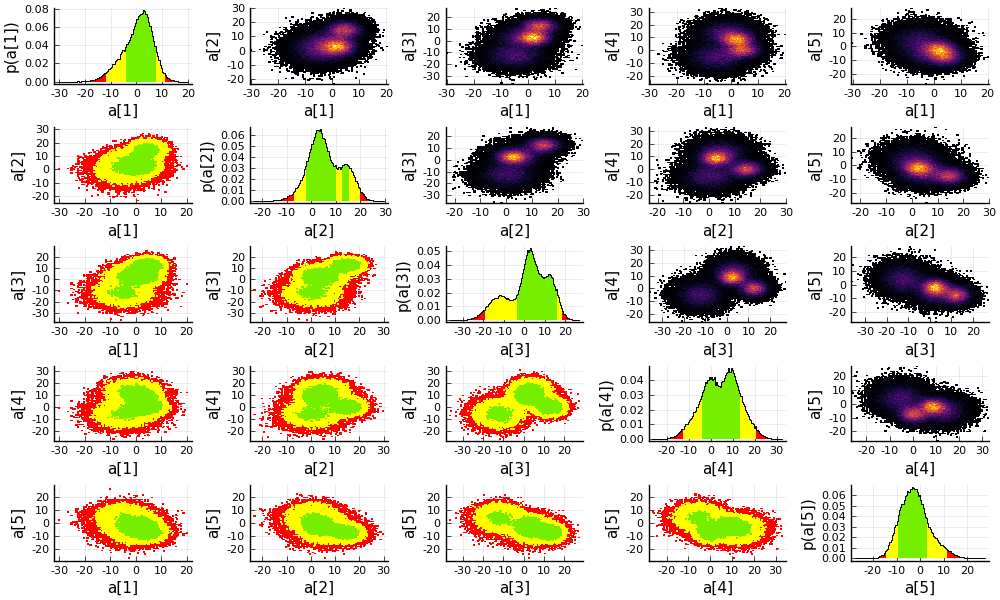

In [10]:
Plots.plot(iid_samples, vsel=[1,2,3,4,5])

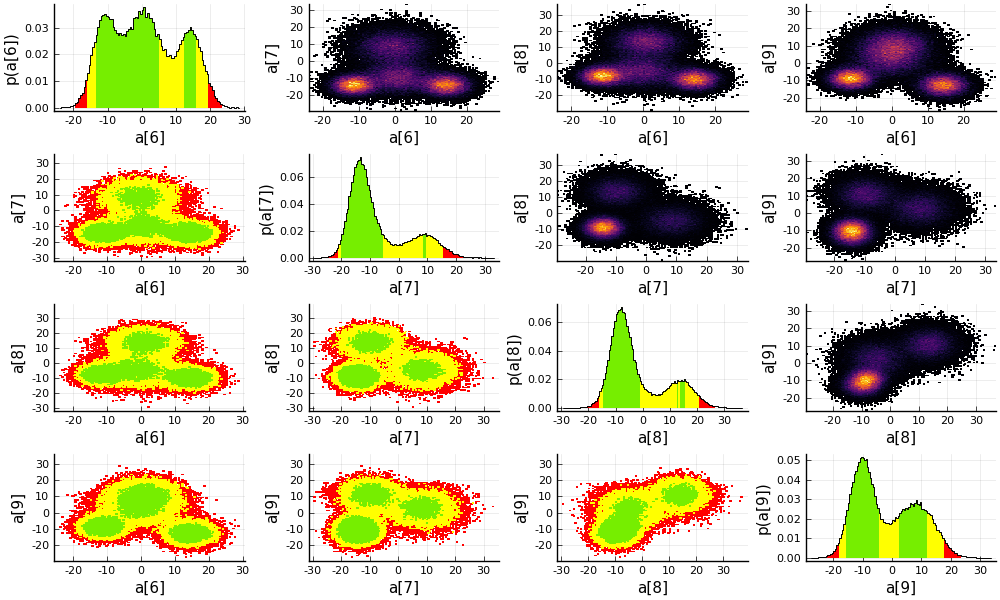

In [11]:
Plots.plot(iid_samples, vsel=[6,7,8,9])

## Parse Data: 

In [12]:
names_1 = ["1-1.", "1-2.", "1-3.", "1-4."]
names_2 = ["2-1.", "2-2.", "2-3.", "2-4."]
names_3 = ["3-1.", "3-2.", "3-3.", "3-4.", "3-5.", "3-6.", "3-7."]
names_4 = ["4-1.", "4-2.", "4-3.", "4-4.", "4-5.", "4-6.", "4-7."]
names_5 = ["5-1.", "5-2.", "5-3.", "5-4.", "5-5.", "5-6.", "5-7."]

path = "../data/Benchmark-1/table"
path2 = "../data/Benchmark-1/samples"

tbl = "csv"
smpl = "hdf5"

"hdf5"

In [13]:
run_1 = Table(
    ind = [1,2,3,4], 
    n_samples = [10^5, 5*10^4, 2*10^4, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_1.*tbl],
    n_subsets = [15,30,75,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_1.*tbl],
    wc_time = [get_wc_time(t) for t in path .* names_1.*tbl],
    integral = [get_integrals(t).val for t in path .* names_1.*tbl],
    integral_err = [get_integrals(t).err for t in path .* names_1.*tbl],
    n_workers = [15 for t in path .* names_1.*tbl],
    n_chains=[10, 10, 10, 10], 
)


run_2 = Table(
    ind = [1,2,3,4], 
    n_chains=[10, 10, 10, 10], 
    n_samples = [6*10^4, 3*10^4, 15*10^3, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_2.*tbl],
    n_subsets = [25,50,100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_2.*tbl],
    wc_time = [get_wc_time(t) for t in path .* names_2.*tbl],
    integral = [get_integrals(t).val for t in path .* names_2.*tbl],
    integral_err = [get_integrals(t).err for t in path .* names_2.*tbl],
    n_workers = [25 for t in path .* names_2.*tbl]
)

run_3 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [3*10^5, 10^5, 6*10^4, 3*10^4, 2*10^4, 15*10^3, 10^4], 
    length_samples = [get_nsamples(t) for t in path.*names_3.*tbl],
    n_subsets = [5, 15, 25, 50, 75, 100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_3.*tbl],
    wc_time = [get_wc_time(t) for t in path .* names_3.*tbl],
    integral = [get_integrals(t).val for t in path .* names_3.*tbl],
    integral_err = [get_integrals(t).err for t in path .* names_3.*tbl],
    n_workers = [5 for t in path .* names_3.*tbl]
)

run_4 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [75*10^4, 375*10^3, 1875*102, 15*10^4, 5*10^4, 15*10^3, 10^4],
    length_samples = [get_nsamples(t) for t in path.*names_4.*tbl],
    n_subsets = [2,4,8,10,30,100,150],
    cpu_time = [get_cpu_time(t) for t in path .* names_4.*tbl],
    wc_time = [get_wc_time(t) for t in path .* names_4.*tbl],
    integral = [get_integrals(t).val for t in path .* names_4.*tbl],
    integral_err = [get_integrals(t).err for t in path .* names_4.*tbl],
    n_workers = [2 for t in path .* names_4.*tbl]
)

run_5 = Table(
    ind = [1,2,3,4,5,6,7], 
    n_chains=[10, 10, 10, 10, 10, 10, 10], 
    n_samples = [15*10^5, 75*10^4, 375*10^3, 1875*102, 15*10^4, 15*10^3, 10^4],
    length_samples = [get_nsamples(t) for t in path.*names_5.*tbl],
    n_subsets = [1, 2, 4, 8, 10, 100, 150],
    cpu_time = [get_cpu_time(t) for t in path .* names_5.*tbl],
    wc_time = [get_wc_time(t) for t in path .* names_5.*tbl],
    integral = [get_integrals(t).val for t in path .* names_5.*tbl],
    integral_err = [get_integrals(t).err for t in path .* names_5.*tbl],
    n_workers = [1 for t in path .* names_5.*tbl]
)

Table with 10 columns and 7 rows:
     ind  n_chains  n_samples  length_samples  n_subsets  cpu_time  wc_time  ⋯
   ┌──────────────────────────────────────────────────────────────────────────
 1 │ 1    10        1500000    13907849        1          24154.3   2535.79  ⋯
 2 │ 2    10        750000     14419784        2          10233.2   1163.15  ⋯
 3 │ 3    10        375000     14675516        4          8437.17   1014.02  ⋯
 4 │ 4    10        191250     14772202        8          8844.38   1108.59  ⋯
 5 │ 5    10        150000     14849758        10         7881.76   989.547  ⋯
 6 │ 6    10        15000      14618758        100        7017.89   1273.84  ⋯
 7 │ 7    10        10000      14670709        150        9711.65   1776.36  ⋯

## Run overview:

### Samples: 

In [14]:
outp_tmp = bat_read(path2 * names_2[4]*smpl)
samples = varshape(prior).(outp_tmp);

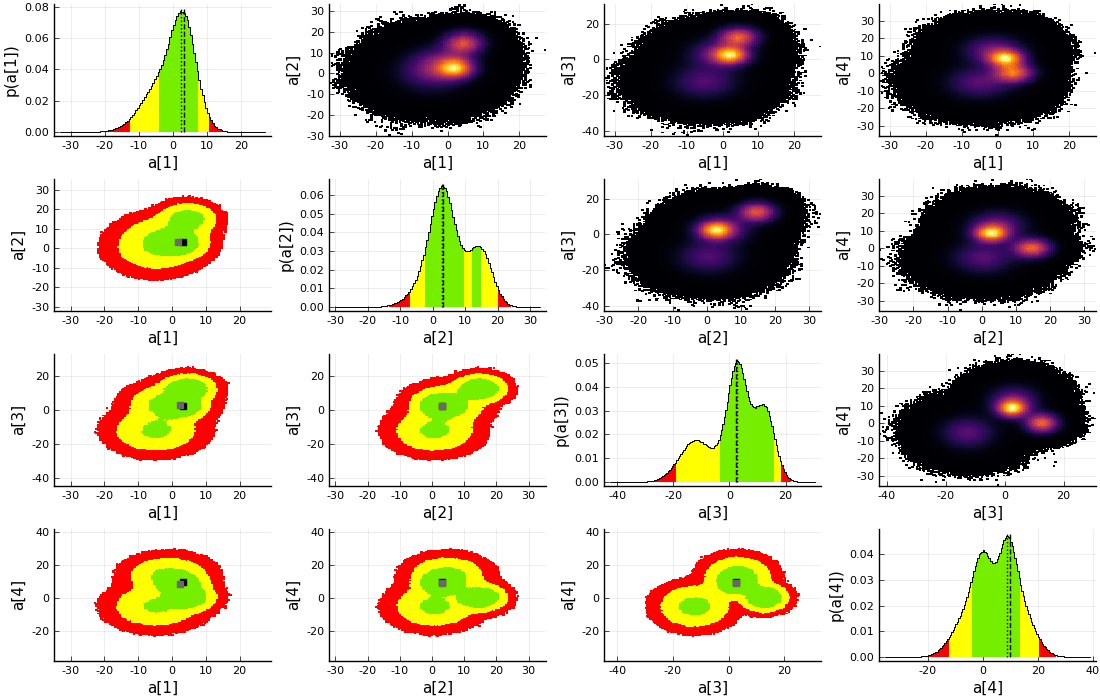

In [15]:
Plots.plot(samples, vsel=[1,2,3,4], size=(1100,700), globalmode=true, localmode=true, 
    upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false,),
)

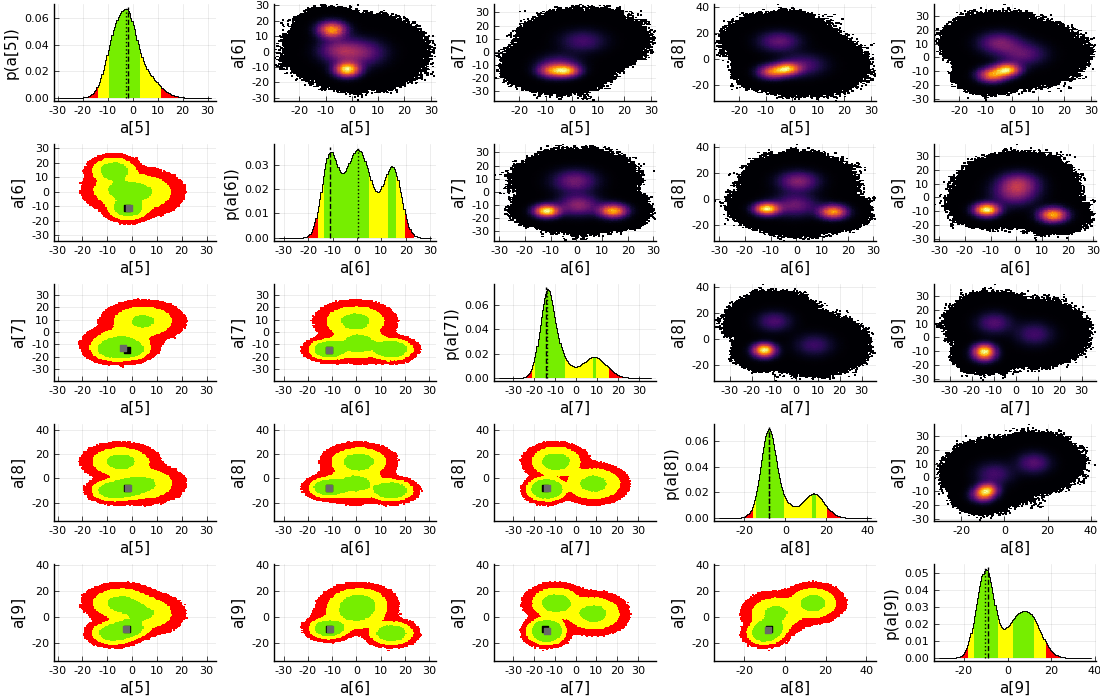

In [16]:
Plots.plot(samples, vsel=[5,6,7,8,9], size=(1100,700), globalmode=true, localmode=true, 
    upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false,),
)

### Run Info:

In [17]:
csvfile = CSV.File(path .* names_2[4]*tbl)
tt = Table(csvfile)
table = convert_to_typed_table(tt);

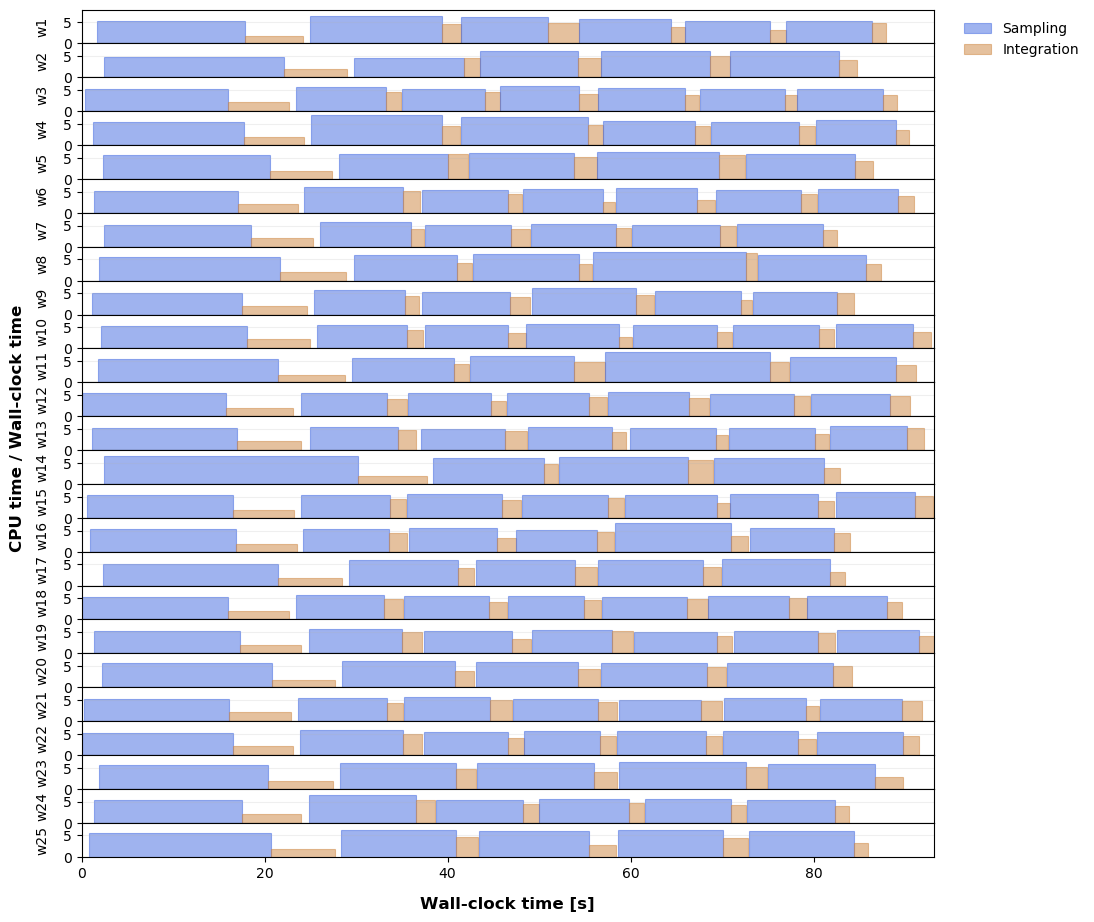

(n_workers, maximum(proc_ids)) = (25, 26)


PyObject Text(0.5, 24.999999999999996, 'Wall-clock time [s]')

In [18]:
plot_separated_timeline(table, figsize=(11,11))

## Time/Integral Benchmark:

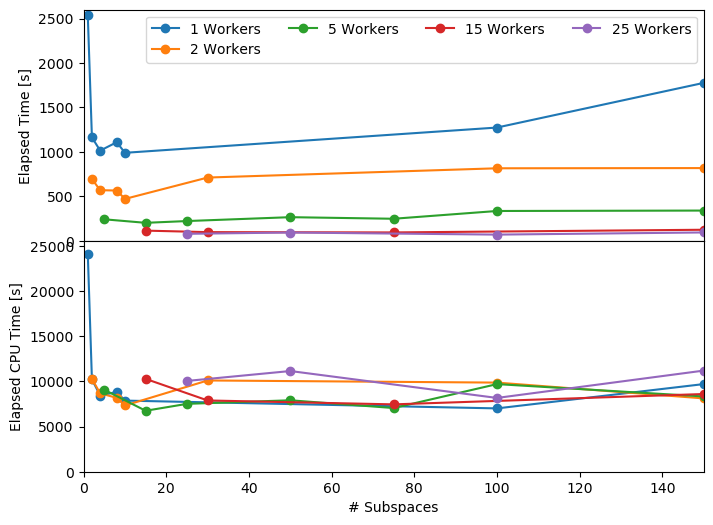

PyObject Text(24.000000000000014, 0.5, 'Elapsed CPU Time [s]')

In [19]:
fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_5.n_subsets, run_5.wc_time, "o-", color="C0", label="1 Workers")
ax[1].plot(run_4.n_subsets, run_4.wc_time, "o-", color="C1", label="2 Workers")
ax[1].plot(run_3.n_subsets, run_3.wc_time, "o-", color="C2", label="5 Workers")
ax[1].plot(run_1.n_subsets, run_1.wc_time, "o-", color="C3", label="15 Workers")
ax[1].plot(run_2.n_subsets, run_2.wc_time, "o-", color="C4", label="25 Workers")
ax[1].set_xlim(0,150)
ax[1].set_ylim(0,2600)

ax[1].set_ylabel("Elapsed Time [s]")
ax[1].legend(ncol=4)

ax[2].plot(run_5.n_subsets, run_5.cpu_time,  "o-", color="C0", label="1 Workers")
ax[2].plot(run_4.n_subsets, run_4.cpu_time,  "o-", color="C1", label="2 Workers")
ax[2].plot(run_3.n_subsets, run_3.cpu_time,  "o-", color="C2", label="5 Workers")
ax[2].plot(run_1.n_subsets, run_1.cpu_time,  "o-", color="C3", label="15 Workers")
ax[2].plot(run_2.n_subsets, run_2.cpu_time,  "o-", color="C4", label="25 Workers")
ax[2].set_xlim(0,150)
ax[2].set_ylim(0,25600)


ax[2].set_xlabel("# Subspaces")
ax[2].set_ylabel("Elapsed CPU Time [s]")

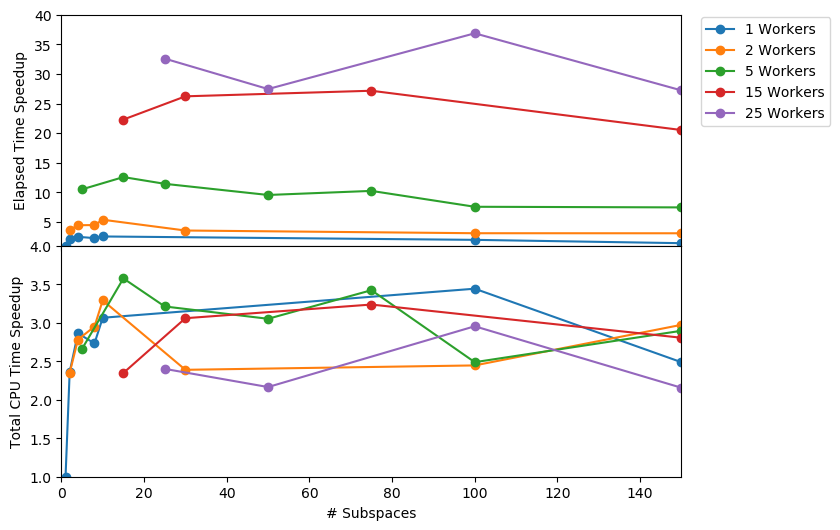

PyObject Text(24.000000000000014, 0.5, 'Total CPU Time Speedup')

In [20]:
r_1_1 = run_5.wc_time[1]
r_1_2 = run_5.cpu_time[1]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_5.n_subsets, r_1_1 ./ run_5.wc_time, "o-", color="C0", label="1 Workers")
ax[1].plot(run_4.n_subsets, r_1_1 ./ run_4.wc_time, "o-", color="C1", label="2 Workers")
ax[1].plot(run_3.n_subsets, r_1_1 ./ run_3.wc_time, "o-", color="C2", label="5 Workers")
ax[1].plot(run_1.n_subsets, r_1_1 ./ run_1.wc_time, "o-", color="C3", label="15 Workers")
ax[1].plot(run_2.n_subsets, r_1_1 ./ run_2.wc_time, "o-", color="C4", label="25 Workers")
ax[1].set_xlim(0,150)
ax[1].set_ylim(1,40)

ax[1].set_ylabel("Elapsed Time Speedup")
ax[1].legend(ncol=1, bbox_to_anchor=(1.02, 1.02))

ax[2].plot(run_5.n_subsets, r_1_2 ./ run_5.cpu_time,  "o-", color="C0", label="1 Workers")
ax[2].plot(run_4.n_subsets, r_1_2 ./ run_4.cpu_time,  "o-", color="C1", label="2 Workers")
ax[2].plot(run_3.n_subsets, r_1_2 ./ run_3.cpu_time,  "o-", color="C2", label="5 Workers")
ax[2].plot(run_1.n_subsets, r_1_2 ./ run_1.cpu_time,  "o-", color="C3", label="15 Workers")
ax[2].plot(run_2.n_subsets, r_1_2 ./ run_2.cpu_time,  "o-", color="C4", label="25 Workers")
ax[2].set_xlim(0,150)
ax[2].set_ylim(1,4)


ax[2].set_xlabel("# Subspaces")
ax[2].set_ylabel("Total CPU Time Speedup")

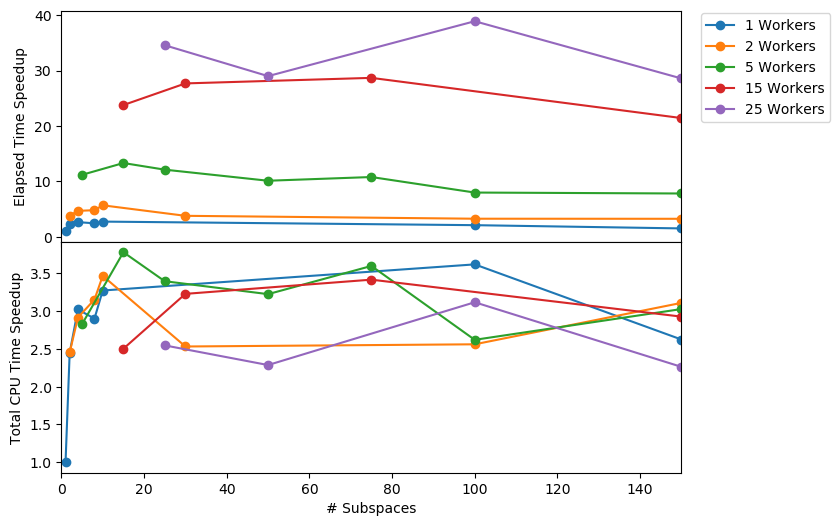

PyObject Text(24.000000000000014, 0.5, 'Total CPU Time Speedup')

In [21]:
r_1_1 = run_5.wc_time[1] / run_5.length_samples[1]
r_1_2 = run_5.cpu_time[1] / run_5.length_samples[1]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=true)

fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].plot(run_5.n_subsets, r_1_1 ./ (run_5.wc_time ./ run_5.length_samples), "o-", color="C0", label="1 Workers")
ax[1].plot(run_4.n_subsets, r_1_1 ./ (run_4.wc_time ./ run_4.length_samples), "o-", color="C1", label="2 Workers")
ax[1].plot(run_3.n_subsets, r_1_1 ./ (run_3.wc_time ./ run_3.length_samples), "o-", color="C2", label="5 Workers")
ax[1].plot(run_1.n_subsets, r_1_1 ./ (run_1.wc_time ./ run_1.length_samples), "o-", color="C3", label="15 Workers")
ax[1].plot(run_2.n_subsets, r_1_1 ./ (run_2.wc_time ./ run_2.length_samples), "o-", color="C4", label="25 Workers")
ax[1].set_xlim(0,150)
# ax[1].set_ylim(1,40)

ax[1].set_ylabel("Elapsed Time Speedup")
ax[1].legend(ncol=1, bbox_to_anchor=(1.02, 1.02))

ax[2].plot(run_5.n_subsets, r_1_2 ./ (run_5.cpu_time  ./ run_5.length_samples),  "o-", color="C0", label="1 Workers")
ax[2].plot(run_4.n_subsets, r_1_2 ./ (run_4.cpu_time  ./ run_4.length_samples),  "o-", color="C1", label="2 Workers")
ax[2].plot(run_3.n_subsets, r_1_2 ./ (run_3.cpu_time  ./ run_3.length_samples),  "o-", color="C2", label="5 Workers")
ax[2].plot(run_1.n_subsets, r_1_2 ./ (run_1.cpu_time  ./ run_1.length_samples),  "o-", color="C3", label="15 Workers")
ax[2].plot(run_2.n_subsets, r_1_2 ./ (run_2.cpu_time  ./ run_2.length_samples),  "o-", color="C4", label="25 Workers")
ax[2].set_xlim(0,150)
# ax[2].set_ylim(1,4)


ax[2].set_xlabel("# Subspaces")
ax[2].set_ylabel("Total CPU Time Speedup")

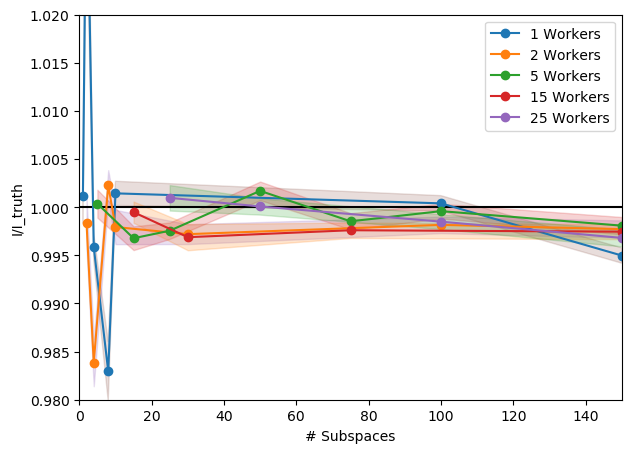

PyObject <matplotlib.legend.Legend object at 0x7f8c2aeee490>

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,5))


ax.plot(run_5.n_subsets, run_5.integral, "o-", color="C0", label="1 Workers")
ax.fill_between(run_5.n_subsets,run_5.integral .- run_5.integral_err, run_5.integral .+ run_5.integral_err, alpha=0.2, color="C5", )

ax.plot(run_4.n_subsets, run_4.integral, "o-", color="C1", label="2 Workers")
ax.fill_between(run_4.n_subsets,run_4.integral .- run_4.integral_err, run_4.integral .+ run_4.integral_err, alpha=0.2, color="C4", )

ax.plot(run_3.n_subsets, run_3.integral, "o-", color="C2", label="5 Workers")
ax.fill_between(run_3.n_subsets,run_3.integral .- run_3.integral_err, run_3.integral .+ run_3.integral_err, alpha=0.2, color="C3", )

ax.plot(run_1.n_subsets, run_1.integral, "o-", color="C3", label="15 Workers")
ax.fill_between(run_1.n_subsets,run_1.integral .- run_1.integral_err, run_1.integral .+ run_1.integral_err, alpha=0.2, color="C1", )

ax.plot(run_2.n_subsets, run_2.integral, "o-", color="C4",  label="25 Workers")
ax.fill_between(run_2.n_subsets,run_2.integral .- run_2.integral_err, run_2.integral .+ run_2.integral_err, alpha=0.2, color="C2", )

ax.hlines([1], 0, 150)

ax.set_xlim(0,150)
ax.set_ylim(0.98,1.02)

ax.set_xlabel("# Subspaces")
ax.set_ylabel("I/I_truth")

ax.legend()

# KS + CS Tests: 

In [23]:
run_1_test = get_table_stat_test("../data/Benchmark-1/run_1_test.csv")
run_2_test = get_table_stat_test("../data/Benchmark-1/run_2_test.csv")
run_3_test = get_table_stat_test("../data/Benchmark-1/run_3_test.csv")
run_4_test = get_table_stat_test("../data/Benchmark-1/run_4_test.csv")
run_5_test = get_table_stat_test("../data/Benchmark-1/run_5_test.csv")

Table with 4 columns and 7 rows:
     exp_ind  n_subsets  ks_p_val                    eff_s_s
   ┌───────────────────────────────────────────────────────────────────────────
 1 │ 1        1          [0.999999, 0.98545, 0.999…  [64244.3, 21722.4, 28343.…
 2 │ 2        2          [0.000390767, 0.143229, 0…  [258824.0, 266053.0, 1557…
 3 │ 3        4          [0.987612, 0.790617, 0.23…  [433806.0, 571935.0, 2044…
 4 │ 4        8          [0.390738, 0.232064, 0.30…  [652476.0, 643433.0, 5054…
 5 │ 5        10         [0.741458, 0.728769, 0.26…  [815792.0, 646247.0, 3242…
 6 │ 6        100        [0.6634, 0.590433, 0.0806…  [869898.0, 854392.0, 7627…
 7 │ 7        150        [0.830454, 0.922718, 0.17…  [880843.0, 898400.0, 8746…

In [24]:
# run_1_test = Table(
#     exp_ind = collect(1:length(names_1)),
#     ks_p_val = [ks_p_vals_array(path*names_1[t]*tbl, path2*names_1[t]*smpl) for t in 1:length(names_1)],
#     n_partitions = [15,30,75,150]
# )

# CSV.write("run_1_stat_test.csv", run_1_test)

# run_2_test = Table(
#     exp_ind = collect(1:length(names_2)),
#     ks_p_val = [ks_p_vals_array(path*names_2[t]*tbl, path2*names_2[t]*smpl) for t in 1:length(names_2)],
#     n_subsets = [25,50,100,150],
# )

# CSV.write("run_2_stat_test.csv", run_2_test)

# run_3_test = Table(
#     exp_ind = collect(1:length(names_3)),
#     ks_p_val = [ks_p_vals_array(path*names_3[t]*tbl, path2*names_3[t]*smpl) for t in 1:length(names_3)],
#     n_subsets = [5, 15, 25, 50, 75, 100,150],
# )

# CSV.write("run_3_stat_test.csv", run_3_test)

# run_4_test = Table(
#     exp_ind = collect(1:length(names_4)),
#     ks_p_val = [ks_p_vals_array(path*names_4[t]*tbl, path2*names_4[t]*smpl) for t in 1:length(names_4)],
#     n_subsets = [2,4,8,10,30,100,150],
# )

# CSV.write("run_4_stat_test.csv", run_4_test)

# run_5_test = Table(
#     exp_ind = collect(1:length(names_5)),
#     ks_p_val = [ks_p_vals_array(path*names_5[t]*tbl, path2*names_5[t]*smpl) for t in 1:length(names_5)],
#     n_subsets = [1, 2, 4, 8, 10, 100, 150],
# )

# CSV.write("run_5_stat_test.csv", run_5_test)

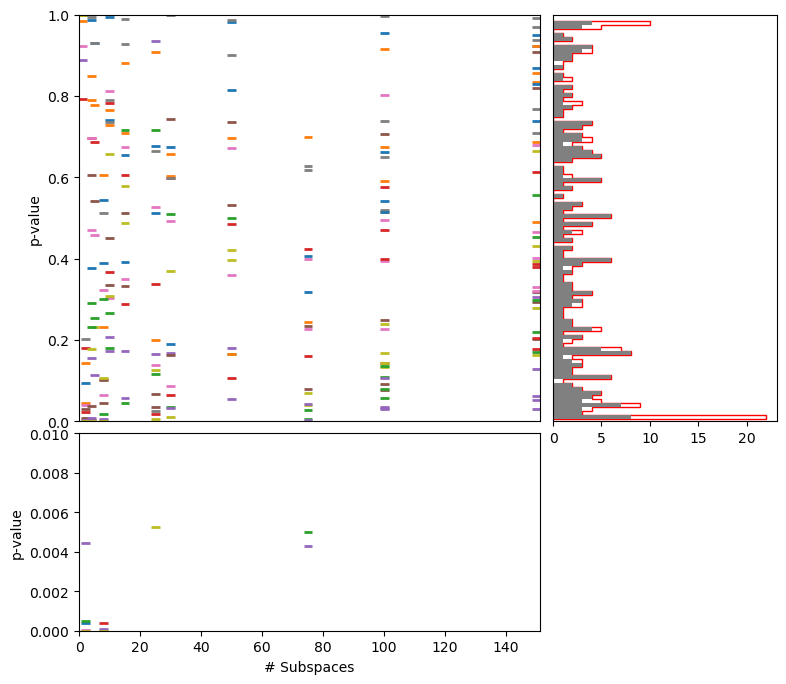

PyObject Text(41.75, 0.5, 'p-value')

In [25]:
fig = plt.figure(figsize=(9,8),)

fig.subplots_adjust(hspace=0.06, wspace=0.06)

mcol = [PyPlot.ColorMap("tab10").colors[i] for i in 1:9]
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2,  xticks=[], )
ax2 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=2,   )
# ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=3,  xticklabels=[], yticklabels=[], xticks=[], yticks=[], )
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=3,  yticklabels=[], yticks=[],)

p_values_array = Float64[]
p_value_array_2 = Float64[]

for i in run_1_test.exp_ind
    ax1.scatter(repeat([run_1_test.n_subsets[i]], length(run_1_test.ks_p_val[i])), run_1_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    ax2.scatter(repeat([run_1_test.n_subsets[i]], length(run_1_test.ks_p_val[i])), run_1_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    append!(p_values_array, run_1_test.ks_p_val[i])
    append!(p_value_array_2, run_1_test.ks_p_val[i])
end

for i in run_2_test.exp_ind
    ax1.scatter(repeat([run_2_test.n_subsets[i]], length(run_2_test.ks_p_val[i])), run_2_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    ax2.scatter(repeat([run_2_test.n_subsets[i]], length(run_2_test.ks_p_val[i])), run_2_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    append!(p_values_array, run_2_test.ks_p_val[i])
    append!(p_value_array_2, run_2_test.ks_p_val[i])
end

for i in run_3_test.exp_ind
    ax1.scatter(repeat([run_3_test.n_subsets[i]], length(run_3_test.ks_p_val[i])), run_3_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    ax2.scatter(repeat([run_3_test.n_subsets[i]], length(run_3_test.ks_p_val[i])), run_3_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    append!(p_values_array, run_3_test.ks_p_val[i])
    append!(p_value_array_2, run_3_test.ks_p_val[i])
end

for i in run_4_test.exp_ind
    ax1.scatter(repeat([run_4_test.n_subsets[i]], length(run_4_test.ks_p_val[i])), run_4_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    ax2.scatter(repeat([run_3_test.n_subsets[i]], length(run_3_test.ks_p_val[i])), run_3_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    append!(p_values_array, run_4_test.ks_p_val[i])
    if run_4_test.n_subsets[i] > 6
        append!(p_value_array_2, run_4_test.ks_p_val[i])
    end
end

for i in run_5_test.exp_ind
    ax1.scatter(repeat([run_5_test.n_subsets[i]], length(run_5_test.ks_p_val[i])), run_5_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
    ax2.scatter(repeat([run_5_test.n_subsets[i]], length(run_5_test.ks_p_val[i])), run_5_test.ks_p_val[i], 
        marker="_", s=40, lw=2, color=mcol,)
     append!(p_values_array, run_5_test.ks_p_val[i])
    if run_5_test.n_subsets[i] > 6
        append!(p_value_array_2, run_5_test.ks_p_val[i])
    end
end

bins = collect(range(-0.00, 1, length=100))

ax3.hist(p_values_array, bins=bins, histtype="step", align="right", color="red", orientation="horizontal",)
ax3.hist(p_value_array_2, bins=bins, histtype="bar", align="right", color="gray", orientation="horizontal",)
ax3.set_ylim(0.0,1.02)

ax1.set_ylim(0,1)
ax2.set_ylim(0,0.01)
ax1.set_xlim(0,151)
ax2.set_xlim(0,151)

ax2.set_xlabel("# Subspaces")
ax2.set_ylabel("p-value")
ax1.set_ylabel("p-value")

# Effective Number of Samples:

In [26]:
# function get_eff_sample_size(sp_samples, sp_table)
    
#     eff_smpl_size_sp = bat_eff_sample_size(unshaped.(sp_samples[sp_table.samples_ind[1]])).result
#     for i in sp_table.samples_ind[2:end]
#         eff_smpl_size_sp += bat_eff_sample_size(unshaped.(sp_samples[i])).result
#     end
    
#     return eff_smpl_size_sp
# end

# function eff_sample_size_array(path_1, path_2; samples_iid=iid_samples)
#     @show "New File"
#     csvfile = CSV.File(path_1)
#     tt = Table(csvfile)
#     table = convert_to_typed_table(tt)
    
#     outp_tmp = bat_read(path_2)
#     samples_sp = varshape(prior).(outp_tmp)
    
#     return get_eff_sample_size(samples_sp, table)
# end

# exp_1 = [eff_sample_size_array("../data/Benchmark-1/"*"table"*i*"csv", "../data/Benchmark-1/"*"samples"*i*"hdf5") for i in names_1]
# exp_2 = [eff_sample_size_array("../data/Benchmark-1/"*"table"*i*"csv", "../data/Benchmark-1/"*"samples"*i*"hdf5") for i in names_2]
# exp_3 = [eff_sample_size_array("../data/Benchmark-1/"*"table"*i*"csv", "../data/Benchmark-1/"*"samples"*i*"hdf5") for i in names_3]
# exp_4 = [eff_sample_size_array("../data/Benchmark-1/"*"table"*i*"csv", "../data/Benchmark-1/"*"samples"*i*"hdf5") for i in names_4]
# exp_5 = [eff_sample_size_array("../data/Benchmark-1/"*"table"*i*"csv", "../data/Benchmark-1/"*"samples"*i*"hdf5") for i in names_5]


# run_1_test = Table(exp_ind = run_1_test.exp_ind, n_subsets = run_1_test.n_subsets, ks_p_val = run_1_test.ks_p_val, eff_s_s = exp_1) 
# CSV.write("run_1_test.csv", run_1_test)

# run_2_test = Table(exp_ind = run_2_test.exp_ind, n_subsets = run_2_test.n_subsets, ks_p_val = run_2_test.ks_p_val, eff_s_s = exp_2) 
# CSV.write("run_2_test.csv", run_2_test)

# run_3_test = Table(exp_ind = run_3_test.exp_ind, n_subsets = run_3_test.n_subsets, ks_p_val = run_3_test.ks_p_val, eff_s_s = exp_3) 
# CSV.write("run_3_test.csv", run_3_test)

# run_4_test = Table(exp_ind = run_4_test.exp_ind, n_subsets = run_4_test.n_subsets, ks_p_val = run_4_test.ks_p_val, eff_s_s = exp_4) 
# CSV.write("run_4_test.csv", run_4_test)

# run_5_test = Table(exp_ind = run_5_test.exp_ind, n_subsets = run_5_test.n_subsets, ks_p_val = run_5_test.ks_p_val, eff_s_s = exp_5) 
# CSV.write("run_5_test.csv", run_5_test)

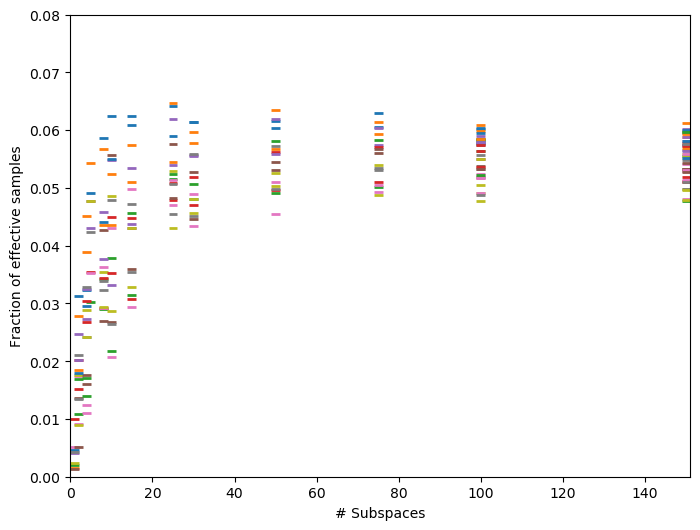

(0, 151)

In [28]:
fig, ax1 = plt.subplots(1,1, figsize=(8,6), sharex=true)



p_values_array = Float64[]
p_value_array_2 = Float64[]

for i in run_1_test.exp_ind
    ax1.scatter(repeat([run_1_test.n_subsets[i]], length(run_1_test.eff_s_s[i])), run_1_test.eff_s_s[i]/run_1.length_samples[i], 
        marker="_", s=40, lw=2, color=mcol,)

    append!(p_values_array, run_1_test.ks_p_val[i])
    append!(p_value_array_2, run_1_test.ks_p_val[i])
end

for i in run_2_test.exp_ind
    ax1.scatter(repeat([run_2_test.n_subsets[i]], length(run_2_test.eff_s_s[i])), run_2_test.eff_s_s[i]/run_2.length_samples[i], 
        marker="_", s=40, lw=2, color=mcol,)
    
    append!(p_values_array, run_2_test.ks_p_val[i])
    append!(p_value_array_2, run_2_test.ks_p_val[i])
end

for i in run_3_test.exp_ind
    ax1.scatter(repeat([run_3_test.n_subsets[i]], length(run_3_test.eff_s_s[i])), run_3_test.eff_s_s[i]/run_3.length_samples[i], 
        marker="_", s=40, lw=2, color=mcol,)

    append!(p_values_array, run_3_test.ks_p_val[i])
    append!(p_value_array_2, run_3_test.ks_p_val[i])
end

for i in run_4_test.exp_ind
    ax1.scatter(repeat([run_4_test.n_subsets[i]], length(run_4_test.eff_s_s[i])), run_4_test.eff_s_s[i]/run_4.length_samples[i], 
        marker="_", s=40, lw=2, color=mcol,)
end

for i in run_5_test.exp_ind
    ax1.scatter(repeat([run_5_test.n_subsets[i]], length(run_5_test.eff_s_s[i])), run_5_test.eff_s_s[i]/run_5.length_samples[i], 
        marker="_", s=40, lw=2, color=mcol,)
end

ax1.set_xlabel("# Subspaces")
ax1.set_ylabel("Fraction of effective samples")

ax1.set_ylim(0,0.08)
ax1.set_xlim(0,151)

To do: 
1. Chi-squared test
2. Write a paper [to be finished by the end of July]           
            
Problems:
1. AHMI does not work correctly for correlated distributions 